# Trabajo práctico N° 2 - Ejercicio 1

### Descripción:

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.
Dataset:
https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

### Objetivo:

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

### Entrega:

La entrega debe incluir:
Código fuente de la solución implementada en Google Colab, que incluya:
- Análisis previo y preprocesamiento del set de datos.

- Definición y entrenamiento del modelo.

- Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


In [92]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from IPython import display


In [21]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

Physical devices cannot be modified after being initialized


In [90]:
df, info = tfds.load('spoken_digit', with_info=True, as_supervised=True)
df_total = df['train']
info

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='/root/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
 

In [40]:
train_proportion = int(0.8 * info.splits['train'].num_examples)
val_proportion = int(0.2 * info.splits['train'].num_examples)
df_train = df_total.take(train_proportion)
df_val = df_total.take(val_proportion)

In [94]:
for example_audio , example_labels in df_train.take(2):
    print(example_audio)
    print(int(example_labels))

tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
2
tf.Tensor([   0    0    0 ... -256    0    0], shape=(2929,), dtype=int64)
1


2025-06-03 23:55:36.581409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


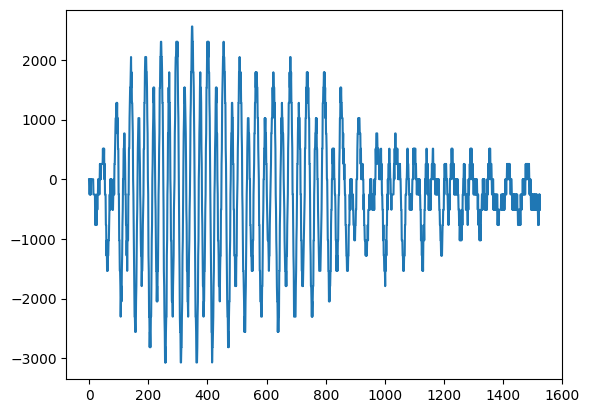

In [ ]:
plt.plot(example_audio)

In [91]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [97]:
for example_audio , example_labels in df_train.take(3):
    example_audio = tf.cast(example_audio, float)
    waveform = example_audio
    spectrogram = get_spectrogram(waveform)

    print('Label:', int(example_labels))
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=8000))

Label: 2
Waveform shape: (1525,)
Spectrogram shape: (10, 129, 1)
Audio playback


Label: 1
Waveform shape: (2929,)
Spectrogram shape: (21, 129, 1)
Audio playback


Label: 9
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


2025-06-04 00:22:59.468120: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
